In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
words = open('/notebooks/first_name.txt', 'r').read().splitlines()
words = [w.lower() for w in words]

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
print(words[:1])
for w in words[:1]:
  print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

['aachal']
aachal
... ---> a
..a ---> a
.aa ---> c
aac ---> h
ach ---> a
cha ---> l
hal ---> .


In [6]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X, dtype = torch.torch.long)
  Y = torch.tensor(Y, dtype = torch.long)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([13163, 3]) torch.Size([13163])
torch.Size([1611, 3]) torch.Size([1611])
torch.Size([1608, 3]) torch.Size([1608])


In [7]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [8]:
sum(p.nelement() for p in parameters) # number of parameters in total

6097

In [9]:
for p in parameters:
  p.requires_grad = True

In [15]:
lri = []
lossi = []
stepi = []

In [16]:
for i in range(20000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 10000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

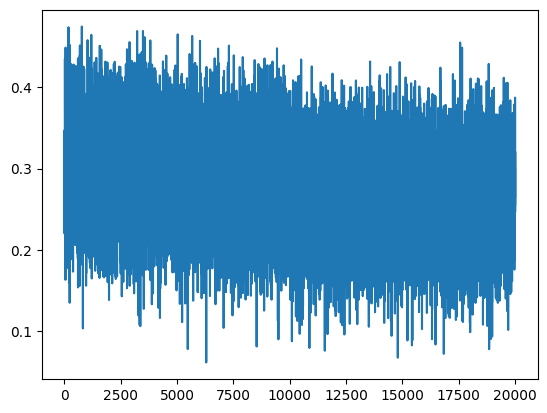

In [17]:
plt.plot(stepi, lossi)

In [18]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(1.8549, grad_fn=<NllLossBackward0>)

In [19]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2978, grad_fn=<NllLossBackward0>)

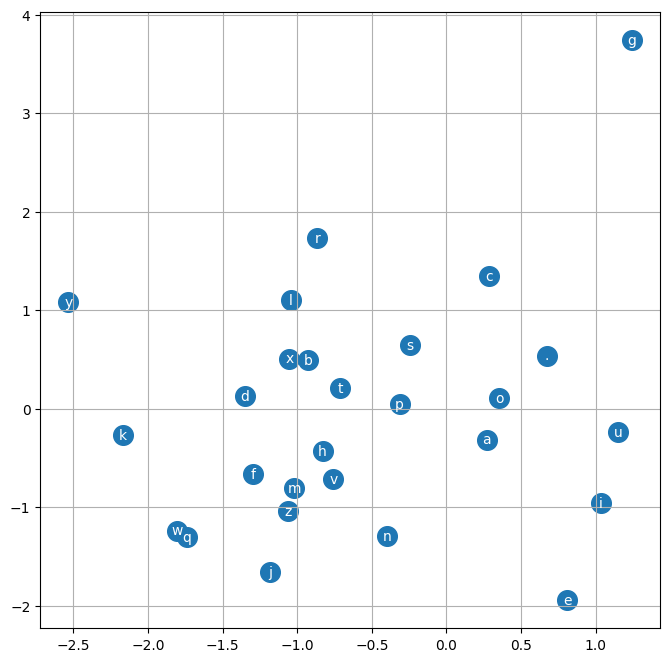

In [ ]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [20]:
# sample from the neural net
g = torch.Generator().manual_seed(2147483646+2)

for i in range(20):
  out = []
  context = [0] * block_size
  while True:
    # forward pass
    emb = C[context] # (32, 3, 10)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
    logits = h @ W2 + b2 # (32, 27)
    # loss = F.cross_entropy(logits, Ytr[ix])
    counts = logits.exp() # counts, equivalent to N
    p = counts / counts.sum(1, keepdims=True) # probabilities for next character
    # ---------

    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    context = context[1:] + [ix]
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

sanjanior.
shaan.
man.
aresh.
debothipasi.
rupamara.
moham.
jyohanti.
apar.
kavyan.
yaket.
juukth.
accaiirenjan.
xarneeth.
rajini.
siddhar.
jul.
upasi.
thanun.
dhrutha.


### implementing the same using nn.Sequential

In [26]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
embedding_dims = 10
neurons_no = 200
C = torch.randn((27, embedding_dims), generator=g)


In [25]:
stepi = []
lossi = []

In [27]:
import torch.nn as nn

# model = nn.Sequential(
#             nn.Linear(block_size * embeding_dims, neurons_no),
#             nn.Tanh(),
#             nn.Linear(neurons_no, 27),
#           )

model = nn.Sequential(
            nn.Embedding(27, embedding_dims),
            nn.Flatten(),
            nn.Linear(block_size * embedding_dims, neurons_no),
            nn.Tanh(),
            nn.Linear(neurons_no, 27),
          )

lr=0.01
momentum=0.9

optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=True)
# scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

for i in range(20000):
  model.train()
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (64,))

  # forward pass
  # emb = C[Xtr[ix]] # (32, 3, 10)
  out = model(Xtr[[ix]])

  loss = F.cross_entropy(out, Ytr[ix])

  #update
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  # scheduler.step()

  stepi.append(i)
  lossi.append(loss.log10().data.item())

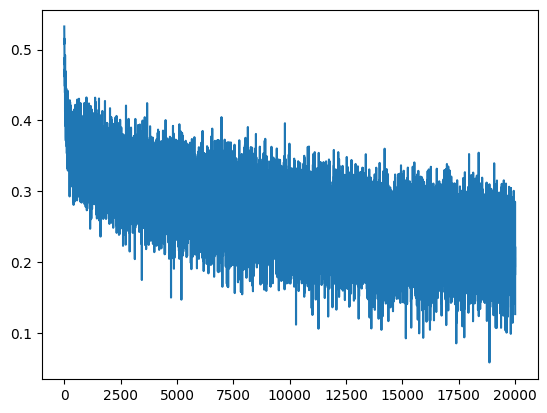

In [28]:
plt.plot(stepi, lossi)

In [31]:
# emb = C[Xtr] # (32, 3, 2)
logits = model(Xtr)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(1.6837, grad_fn=<NllLossBackward0>)

In [32]:
# emb = C[Xdev] # (32, 3, 2)
logits = model(Xdev)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2687, grad_fn=<NllLossBackward0>)

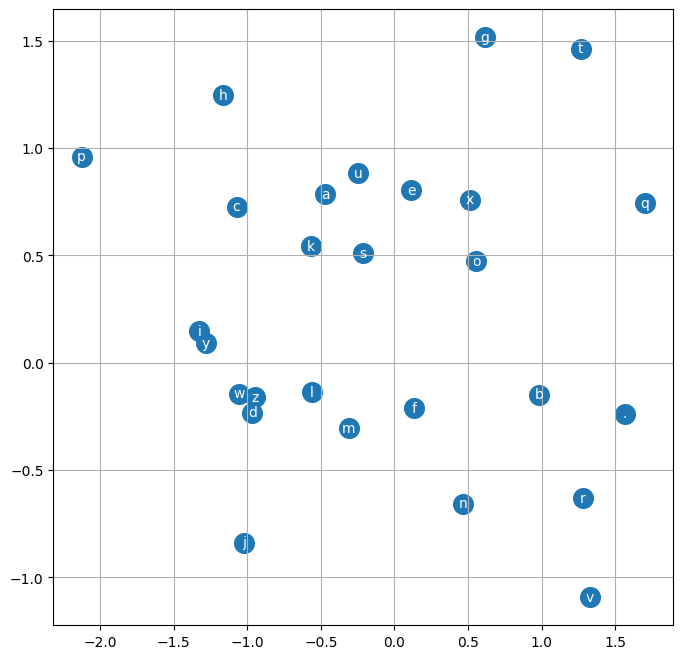

In [ ]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [33]:
# sample from the neural net
g = torch.Generator().manual_seed(2147483646+2)

for i in range(20):
  out = []
  context = [0] * block_size
  while True:
    # forward pass
    emb = C[context] # (32, 3, 10)
    # h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
    # logits = h @ W2 + b2 # (32, 27)
    logits = model(torch.tensor([context]))
    # loss = F.cross_entropy(logits, Ytr[ix])
    counts = logits.exp() # counts, equivalent to N
    p = counts / counts.sum(1, keepdims=True) # probabilities for next character
    # ---------

    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    context = context[1:] + [ix]
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

sanjumilamsleed.
manna.
ridumalavalp.
adirumani.
vidra.
manna.
sanjumporekaramna.
dharushu.
elangeetika.
jogeya.
kona.
vishi.
latika.
aadjun.
oishiratenu.
thant.
taraghar.
vinal.
want.
geet.
